In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from time import sleep
from sklearn import cross_validation, ensemble
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import interp
 
%matplotlib inline

c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 3\\Combined_News_DJIA.csv')

In [5]:
df.tail(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
1988,2016-07-01,1,A 117-year-old woman in Mexico City finally re...,IMF chief backs Athens as permanent Olympic host,"The president of France says if Brexit won, so...",British Man Who Must Give Police 24 Hours' Not...,100+ Nobel laureates urge Greenpeace to stop o...,Brazil: Huge spike in number of police killing...,Austria's highest court annuls presidential el...,"Facebook wins privacy case, can track any Belg...",...,"The United States has placed Myanmar, Uzbekist...",S&amp;P revises European Union credit rating t...,India gets $1 billion loan from World Bank for...,U.S. sailors detained by Iran spoke too much u...,Mass fish kill in Vietnam solved as Taiwan ste...,Philippines president Rodrigo Duterte urges pe...,Spain arrests three Pakistanis accused of prom...,"Venezuela, where anger over food shortages is ...",A Hindu temple worker has been killed by three...,Ozone layer hole seems to be healing - US &amp...


In [6]:
news = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 3\\RedditNews.csv')

In [7]:
news.tail(2)

,Date,News
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."
73607,2008-06-08,"b'Marriage, they said, was reduced to the stat..."


In [8]:
djia = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 3\\DJIA_Table.csv')

In [9]:
djia.head(2)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234


In [10]:
djia['Label'] = np.where(djia['Close'] > djia['Open'], 1, 0)

In [11]:
testmerge = pd.merge(news, djia[['Date', 'Label']], on='Date', how = 'left')

In [12]:
testmerge = testmerge.groupby('Date')['News'].apply(' '.join).reset_index()

In [13]:
testmerge.head()

,Date,News
0,2008-06-08,b'Nim Chimpsky: The tragedy of the chimp who t...
1,2008-06-09,"b'United States quits Human Rights Council' b""..."
2,2008-06-10,"b'Oil shortage a myth, says industry insider' ..."
3,2008-06-11,b'BBC uncovers lost Iraq billions' b'War Crimi...
4,2008-06-12,"b'Did US attack Pakistan last night? ""Pakistan..."


In [14]:
df = pd.merge(testmerge, djia[['Date', 'Label', 'Open', 'Close', 'High', 'Low', 'Volume']], on = 'Date', how = 'left')

In [16]:
#Good - that worked as planned. Now stagger the data by 1 day such that the headlines are aligned with the FOLLOWING 
#day's stock indicator

df2 = df[['Label', 'Date', 'Open', 'Close', 'Volume']].reset_index(drop = True)
#Drop the first row which is the oldest date
df2 = df2.drop(0)
#Drop last row of headline information which is the most recent
df = df.drop(len(df) -1)

In [17]:
df2 = df2.reset_index(drop = True)
df['Label'] = df2['Label']
df['Date'] = df2['Date']


#Append Friday's open/close/volume data for Monday's row (so that we can predict Monday's Movement on Sunday)
for row in range(len(df)):
    if row == 0:
        df['Open'][row] = np.nan
        df['Close'][row] = np.nan
        df['High'][row] = np.nan
        df['Low'][row] = np.nan
        df['Volume'][row] = np.nan
    elif np.isnan(df['Open'][row]):
        df['Open'][row] = df['Open'][row - 1]
        df['Close'][row] = df['Close'][row - 1]
        df['High'][row] = df['High'][row - 1]
        df['Low'][row] = df['Low'][row - 1]
        df['Volume'][row] = df['Volume'][row - 1]

c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36-32\lib

In [223]:
#Now drop the weekend days where there is no up/down label to predict
df = df.dropna()

#Make sure it worked
#df.head(10)
#It did. Now we have the stock market performance by date, with the PRIOR day's headlines & OPEN & CLOSE & Volume

In [19]:
#Rename Columns to reflect changes
df.columns = ['Date', 'Prior_News', 'Label', 'Prior_Open', 'Prior_Close', 'Prior_High', 'Prior_Low', 'Prior_Volume']

#Add another feature for prior day's label
df['Prior_Label'] = np.where(df['Prior_Close'] > df['Prior_Open'], 1, 0)
df = df.reset_index(drop = True)

In [20]:
#Now clean up the News Headlines a bit
df['Prior_News'] = df['Prior_News'].apply(lambda x: str(x).replace("b'", ""))
df['Prior_News'] = df['Prior_News'].apply(lambda x: str(x).replace("b\"", ""))

In [210]:
#Determine minimum target accuracy for a model, ie what would happen if we predicted 1 every time (whole dataset)?
print('Probability of Increase:', sum(df['Label'])/len(df))

Probability of Increase: 0.541247484909


In [31]:
#Let's also classify the daily news headline sentiment and generate some new features build our model on
global count 

import requests
from time import sleep

def analyze_headline(headline):
    payload = {'text': headline}
    req = requests.post('http://text-processing.com/api/sentiment/', data=payload)
    if req.status_code == 200:
        j = req.json()
        sleep(0) # trottle requests to avoid getting blacklisted
        print(j) # print full JSON responce to screen for checking 
        return j["probability"]['neg'], j["probability"]['neutral'], j["probability"]['pos'] 
    else:
        return np.nan

In [231]:
#Run partial df... API is limited to 1K hits per day... so break it up 
df_sent1 = pd.DataFrame()
df_sent1['Sentiment'] = df['Prior_News'][:500].apply(lambda x: analyze_headline(x))

{'probability': {'neg': 0.6041507541427137, 'neutral': 0.6317929693191509, 'pos': 0.3958492458572863}, 'label': 'neutral'}
{'probability': {'neg': 0.33373223694850407, 'neutral': 0.8750133648536189, 'pos': 0.6662677630514959}, 'label': 'neutral'}
{'probability': {'neg': 0.4872853129316126, 'neutral': 0.8179798460837162, 'pos': 0.5127146870683874}, 'label': 'neutral'}
{'probability': {'neg': 0.3420476532181327, 'neutral': 0.8698412698308121, 'pos': 0.6579523467818673}, 'label': 'neutral'}
{'probability': {'neg': 0.52937856513074, 'neutral': 0.8616490401455007, 'pos': 0.47062143486926}, 'label': 'neutral'}
{'probability': {'neg': 0.21321781172016396, 'neutral': 0.8872255999854115, 'pos': 0.786782188279836}, 'label': 'neutral'}
{'probability': {'neg': 0.4052453608166243, 'neutral': 0.8388538158693931, 'pos': 0.5947546391833757}, 'label': 'neutral'}
{'probability': {'neg': 0.5333044972464249, 'neutral': 0.9003998316496915, 'pos': 0.466695502753575}, 'label': 'neutral'}
{'probability': {'ne

In [228]:
df_sent2 = pd.DataFrame()
df_sent2['Sentiment'] = df['Prior_News'][500:1000].apply(lambda x: analyze_headline(x))

In [229]:
df_sent3 = pd.DataFrame()
df_sent3['Sentiment'] = df['Prior_News'][1000:1500].apply(lambda x: analyze_headline(x))

In [230]:
df_sent4 = pd.DataFrame()
df_sent4['Sentiment'] = df['Prior_News'][1500:].apply(lambda x: analyze_headline(x))

In [37]:
#Combine into one DF column
df_sent = pd.DataFrame()
df_sent = pd.concat([df_sent1, df_sent2, df_sent3, df_sent4], axis = 0)

In [38]:
neg_sent = []
neut_sent = []
pos_sent = []

for row in range(len(df)):
    neg_sent.append(df_sent.iloc[row, 0][0])
    neut_sent.append(df_sent.iloc[row, 0][1])
    pos_sent.append(df_sent.iloc[row, 0][2])
df['Neg_Sentiment'] = neg_sent
df['Neutral_Sentiment'] = neut_sent
df['Pos_Sentiment'] = pos_sent

In [39]:
#Because neutral dominates the classifcations, let's forcibly divide the classes into thirds (neg/neutral/pos) based on ranking
df['Neg_Rank'] = df['Neg_Sentiment'].rank(axis = 0, ascending = False)
df['Neutral_Rank'] = df['Neutral_Sentiment'].rank(axis = 0, ascending = False)
df['Pos_Rank'] = df['Pos_Sentiment'].rank(axis = 0, ascending = False)

df['Pos_Headlines'] = 0
df['Neutral_Headlines'] = 0
df['Neg_Headlines'] = 0

for row in range(len(df)):
    low_rank = min(df['Neg_Rank'][row], df['Neutral_Rank'][row], df['Pos_Rank'][row])
    if df['Neg_Rank'][row] == low_rank:
        df['Neg_Headlines'][row] = 1
    elif df['Neutral_Rank'][row] == low_rank:
        df['Neutral_Headlines'][row] = 1
    else:
        df['Pos_Headlines'][row] = 1

c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
#Add a feature for 20, 50, 200 day moving averages
df_ma = pd.DataFrame() 
df_ma = pd.merge(df, djia[['Date', 'Open', 'Close']], on='Date', how = 'inner') 

df_ma['MA_21'] = df_ma['Close'].rolling(window = 21, center = False).mean() 
df_ma['MA_50'] = df_ma['Close'].rolling(window = 50, center = False).mean() 
df_ma['MA_200'] = df_ma['Close'].rolling(window = 200, center = False).mean() 

df_ma['Bollinger_21_Up'] = df_ma['MA_21'] + (2 * (df_ma['Close'].rolling(window = 21, center = False).std()))
df_ma['Bollinger_21_Down'] = df_ma['MA_21'] - (2 * (df_ma['Close'].rolling(window = 21, center = False).std()))

#df['Sentiment'] = df_sent['Sentiment']
df = df.reset_index(drop = True)
df['MA_21_Diff'] = df_ma['Open'] - df_ma['MA_21'] 
df['MA_50_Diff'] = df_ma['Open'] - df_ma['MA_50'] 
df['MA_200_Diff'] = df_ma['Open'] - df_ma['MA_200']

#Add additional technical features to increase discrimination in model 

df['WPR'] = -100 * ((df['Prior_Close'].rolling(window = 14, center = False).max() - df['Prior_Close']) / (df['Prior_Close'].rolling(window = 14, center = False).max() - df['Prior_Close'].rolling(window = 14, center = False).min()))

df['Rate_Of_Change'] = 0
for i in range(len(df)):
    if i <= 1:
        df['Rate_Of_Change'][i] = np.nan
    else: 
        df['Rate_Of_Change'][i] = (df['Prior_Close'][i] - df['Prior_Close'][i - 2]) / df['Prior_Close'][i - 2]
        
df['Typical_Price'] = (df['Prior_Close'] + df['Prior_High'] + df['Prior_Low']) / 3
df['Typical_Price_20d_MA'] = df['Typical_Price'].rolling(window = 20, center = False).mean()

for row in range(len(df)):
    if row <= 19:
        df['Mean_Deviation'] = np.nan
    else:
        df['Mean_Deviation'][row] = (abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-1]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-2]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-3]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-4]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-5]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-6]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-7]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-8]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-9]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-10]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-11]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-12]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-13]) + 
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-14]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-15]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-16]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-17]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-18]) +
                                    abs(df['Typical_Price_20d_MA'][row] - df['Typical_Price'][row-19])) / 20 

df['CCI'] = (df['Typical_Price'] - df['Typical_Price_20d_MA']) / (0.015 * df['Mean_Deviation'])

c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\r

In [41]:
#Create final dataframe to use in model development

df_clean = pd.DataFrame()
df_clean['Prior_Label'] = df['Prior_Label']
df_clean['MA_21_Diff'] = df['MA_21_Diff']
df_clean['Pos_Sentiment'] = df['Pos_Headlines']
df_clean['Neutral_Sentiment'] = df['Neutral_Headlines']
df_clean['Neg_Sentiment'] = df['Neg_Headlines']
df_clean['Prior_Change'] = (df['Prior_Close'] - df['Prior_Open']) / df['Prior_Open']
df_clean['Prior_Volume'] = df['Prior_Volume']
df_clean['Bolinger_Up_Diff'] = (df_ma['Bollinger_21_Up'] - df['Prior_Close']) / df['Prior_Close']
df_clean['Bolinger_Down_Diff'] = (df_ma['Bollinger_21_Down'] - df['Prior_Close']) / df['Prior_Close']
df_clean['WPR'] = df['WPR']
df_clean['Rate_Of_Change'] = df['Rate_Of_Change']
df_clean['CCI'] = df['CCI']

#Add RSI Indicator to DF
# Get just the close
close = df['Prior_Close']
# Get the difference in price from previous step
delta = close.diff()
# Get rid of the first row, which is NaN since it did not have a previous 
# row to calculate the differences
#delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

# Calculate the EWMA on 14-day window (per Wikipedia, 14 is commonly used)
roll_up1 = pd.stats.moments.ewma(up, 14)
roll_down1 = pd.stats.moments.ewma(down.abs(), 14)

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

df_clean['RSI'] = RSI1
df_clean['Label'] = df['Label']

c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=14,min_periods=0,adjust=True,ignore_na=False).mean()
c:\users\ryan\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=14,min_periods=0,adjust=True,ignore_na=False).mean()


In [42]:
df_temp = pd.DataFrame()

df_temp = df_clean.iloc[:, :13]
df_temp['Prior_News'] = df['Prior_News']
df_temp['Label'] = df['Label']
df_temp['Date'] = df['Date']

#Add CURRENT open and close price solely so we can determine the model gain/loss on actual data (Will not be used to train)
df_temp = pd.merge(df_temp, djia[['Date', 'Open', 'Close']], on = 'Date', how = 'left')
#df_temp.tail()

In [221]:
#Text Vectorization (without sentiment) Model Comparisons: Without technical indicator features

#Cannot run Naive Bayes, GBM because it requires a dense matrix and I cannot convert to an array without crashing (Memory issues)

rfc_overall = []
svc_overall = []
logit_overall = []
#gbm_overall = []
#gbm2_overall = []
#gnb_overall = []

for i in range(3):
    
        X = df_temp.iloc[:, :14].dropna()
        y1 = df_temp.dropna()
        y = y1['Label']

        rfc_accuracy = []
        svc_accuracy = []
        logit_accuracy = []
        #gbm_accuracy = []
        #gbm2_accuracy = []
        #gnb_accuracy = []
        
        rfc_auc = []
        svc_auc = []
        logit_auc = []

        test_no = 1
        kf = KFold(n_splits=8, shuffle = True)

        for train_index, test_index in kf.split(X, y):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            train_headlines_list = X_train['Prior_News']
            test_headlines_list = X_test['Prior_News']

            tvec = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range=(2,2))

            train_features = tvec.fit_transform(train_headlines_list)    
            test_features = tvec.transform(test_headlines_list) #Do not re-fit, just create counts based on the train data word list


            
            rfc = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced')#, max_features = 'auto', max_depth = 3)
            rfc = rfc.fit(train_features, y_train)

            svc = SVC(class_weight = 'balanced', probability = True)
            svc = svc.fit(train_features, y_train)

            logit = LogisticRegression(class_weight = 'balanced')
            logit = logit.fit(train_features, y_train)

            #gbm = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'deviance')
            #gbm.fit(train_features, y_train)
            
            #gbm2 = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'exponential')
            #gbm2.fit(train_features, y_train)
            
            #gnb = GaussianNB()
            #gnb.fit(train_features, y_train)
            
            predicted = rfc.predict(test_features)
            predicted2 = svc.predict(test_features)
            predicted3 = logit.predict(test_features)
            #predicted4 = gbm.predict(test_features)
            #predicted5 = gbm2.predict(test_features)
            #predicted6 = gnb.predict(test_features)
            
            actual = y_test
            #print('Fold:', test_no)
            #print('Accuracy:', 1 - (actual!=predicted).sum()/len(actual))
            
            rfc_accuracy.append(1 - (actual!=predicted).sum()/len(actual))
            svc_accuracy.append(1 - (actual!=predicted2).sum()/len(actual))
            logit_accuracy.append(1 - (actual!=predicted3).sum()/len(actual))
            #gbm_accuracy.append(1 - (actual!=predicted4).sum()/len(actual))
            #gbm2_accuracy.append(1 - (actual!=predicted5).sum()/len(actual))
            #gnb_accuracy.append(1 - (actual!=predicted6).sum()/len(actual))
            
            rfc_auc.append(roc_auc_score(actual, rfc.predict_proba(test_features)[:, 1]))
            svc_auc.append(roc_auc_score(actual, svc.predict_proba(test_features)[:, 1]))
            logit_auc.append(roc_auc_score(actual, logit.predict_proba(test_features)[:, 1]))
            
            test_no = test_no + 1

        print('Test Number:', i+1)
        print('RFC ROC-AUC Score:', np.mean(rfc_auc))
        print('SVC ROC-AUC Score:', np.mean(svc_auc))
        print('Logit ROC-AUC Score:', np.mean(logit_auc))
        
        print('RF Average Accuracy:', np.mean(rfc_accuracy))
        print('SVC Average Accuracy:', np.mean(svc_accuracy))
        print('Logit Average Accuracy:', np.mean(logit_accuracy))
        #print('GBM Average Accuracy:', np.mean(gbm_accuracy))
        #print('GBM2 Average Accuracy:', np.mean(gbm2_accuracy))
        #print('GNB Average Accuracy:', np.mean(gnb_accuracy))
        print('')
        
        rfc_overall.append(np.mean(rfc_accuracy))
        svc_overall.append(np.mean(svc_accuracy))
        logit_overall.append(np.mean(logit_accuracy))
        #gbm_overall.append(np.mean(gbm_accuracy))
        #gbm2_overall.append(np.mean(gbm2_accuracy))
        #gnb_overall.append(np.mean(gnb_accuracy))

print('RF Multi-Run Average Accuracy:', np.mean(rfc_overall))
print('SVC Multi-Run Average Accuracy:', np.mean(svc_overall))
print('Logit Multi-Run Average Accuracy:', np.mean(logit_overall))
#print('GBM Multi-Run Average Accuracy:', np.mean(gbm_overall))
#print('GBM2 Multi-Run Average Accuracy:', np.mean(gbm2_overall))
#print('GNB Multi-Run Average Accuracy:', np.mean(gnb_overall))

Test Number: 1
RFC ROC-AUC Score: 0.516224976892
SVC ROC-AUC Score: 0.489026349323
Logit ROC-AUC Score: 0.511700517884
RF Average Accuracy: 0.534552845528
SVC Average Accuracy: 0.482723577236
Logit Average Accuracy: 0.519817073171

Test Number: 2
RFC ROC-AUC Score: 0.484282043416
SVC ROC-AUC Score: 0.500161529379
Logit ROC-AUC Score: 0.500711473496
RF Average Accuracy: 0.529471544715
SVC Average Accuracy: 0.47256097561
Logit Average Accuracy: 0.528963414634

Test Number: 3
RFC ROC-AUC Score: 0.51085415189
SVC ROC-AUC Score: 0.493181772093
Logit ROC-AUC Score: 0.507206633032
RF Average Accuracy: 0.542682926829
SVC Average Accuracy: 0.467479674797
Logit Average Accuracy: 0.533028455285

RF Multi-Run Average Accuracy: 0.535569105691
SVC Multi-Run Average Accuracy: 0.474254742547
Logit Multi-Run Average Accuracy: 0.527269647696


In [226]:
#tvec.vocabulary_

In [211]:
#Text Vectorization (without sentiment) Model Comparisons: With newly added technical indicator features

#Cannot run Naive Bayes, GBM because it requires a dense matrix and I cannot convert to an array without crashing (Memory issues)

rfc_overall = []
svc_overall = []
logit_overall = []
#gbm_overall = []
#gbm2_overall = []
#gnb_overall = []

for i in range(3):
    
        X = df_temp.iloc[:, :14].dropna()
        y1 = df_temp.dropna()
        y = y1['Label']

        rfc_accuracy = []
        svc_accuracy = []
        logit_accuracy = []
        #gbm_accuracy = []
        #gbm2_accuracy = []
        #gnb_accuracy = []
        
        rfc_auc = []
        svc_auc = []
        logit_auc = []

        test_no = 1
        kf = KFold(n_splits=8, shuffle = True)

        for train_index, test_index in kf.split(X, y):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            train_headlines_list = X_train['Prior_News']
            test_headlines_list = X_test['Prior_News']

            tvec = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range=(2,2))
            #tvec = CountVectorizer(ngram_range=(2,2))
            train_features = tvec.fit_transform(train_headlines_list)
            
            #Add our prior label feature into the train features
            x = csr_matrix(X_train['Prior_Label'].values.reshape(-1,1))
            x2 = csr_matrix(X_train['MA_21_Diff'].values.reshape(-1,1))
            #x31 = csr_matrix(X_train['Pos_Sentiment'].values.reshape(-1,1))
            #x32 = csr_matrix(X_train['Neutral_Sentiment'].values.reshape(-1,1))
            #x33 = csr_matrix(X_train['Neg_Sentiment'].values.reshape(-1,1))
            x4 = csr_matrix(X_train['Prior_Change'].values.reshape(-1,1))
            x5 = csr_matrix(X_train['Prior_Volume'].values.reshape(-1,1))
            x6 = csr_matrix(X_train['Bolinger_Up_Diff'].values.reshape(-1,1))
            x7 = csr_matrix(X_train['Bolinger_Down_Diff'].values.reshape(-1,1))
            x8 = csr_matrix(X_train['RSI'].values.reshape(-1,1))
            x9 = csr_matrix(X_train['WPR'].values.reshape(-1,1))
            x10 = csr_matrix(X_train['Rate_Of_Change'].values.reshape(-1,1))
            x11 = csr_matrix(X_train['CCI'].values.reshape(-1,1))
            train_features = hstack([train_features, x, x2, x4, x5, x6, x7, x8, x9, x10, x11])
            
            test_features = tvec.transform(test_headlines_list) #Do not re-fit, just create counts based on the train data word list

            #Add our prior label feature into the test features
            x = csr_matrix(X_test['Prior_Label'].values.reshape(-1,1))
            x2 = csr_matrix(X_test['MA_21_Diff'].values.reshape(-1,1))
            #x31 = csr_matrix(X_test['Pos_Sentiment'].values.reshape(-1,1))
            #x32 = csr_matrix(X_test['Neutral_Sentiment'].values.reshape(-1,1))
            #x33 = csr_matrix(X_test['Neg_Sentiment'].values.reshape(-1,1))
            x4 = csr_matrix(X_test['Prior_Change'].values.reshape(-1,1))
            x5 = csr_matrix(X_test['Prior_Volume'].values.reshape(-1,1))
            x6 = csr_matrix(X_test['Bolinger_Up_Diff'].values.reshape(-1,1))
            x7 = csr_matrix(X_test['Bolinger_Down_Diff'].values.reshape(-1,1))
            x8 = csr_matrix(X_test['RSI'].values.reshape(-1,1))
            x9 = csr_matrix(X_test['WPR'].values.reshape(-1,1))
            x10 = csr_matrix(X_test['Rate_Of_Change'].values.reshape(-1,1))
            x11 = csr_matrix(X_test['CCI'].values.reshape(-1,1))
            test_features = hstack([test_features, x, x2, x4, x5, x6, x7, x8, x9, x10, x11])
            
            rfc = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced')#, max_features = 'auto', max_depth = 3)
            rfc = rfc.fit(train_features, y_train)

            svc = SVC(class_weight = 'balanced', probability = True)
            svc = svc.fit(train_features, y_train)

            logit = LogisticRegression(class_weight = 'balanced')
            logit = logit.fit(train_features, y_train)

            #gbm = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'deviance')
            #gbm.fit(train_features, y_train)
            
            #gbm2 = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'exponential')
            #gbm2.fit(train_features, y_train)
            
            #gnb = GaussianNB()
            #gnb.fit(train_features, y_train)
            
            predicted = rfc.predict(test_features)
            predicted2 = svc.predict(test_features)
            predicted3 = logit.predict(test_features)
            #predicted4 = gbm.predict(test_features)
            #predicted5 = gbm2.predict(test_features)
            #predicted6 = gnb.predict(test_features)
            
            actual = y_test
            #print('Fold:', test_no)
            #print('Accuracy:', 1 - (actual!=predicted).sum()/len(actual))
            
            rfc_accuracy.append(1 - (actual!=predicted).sum()/len(actual))
            svc_accuracy.append(1 - (actual!=predicted2).sum()/len(actual))
            logit_accuracy.append(1 - (actual!=predicted3).sum()/len(actual))
            #gbm_accuracy.append(1 - (actual!=predicted4).sum()/len(actual))
            #gbm2_accuracy.append(1 - (actual!=predicted5).sum()/len(actual))
            #gnb_accuracy.append(1 - (actual!=predicted6).sum()/len(actual))
            
            rfc_auc.append(roc_auc_score(actual, rfc.predict_proba(test_features)[:, 1]))
            svc_auc.append(roc_auc_score(actual, svc.predict_proba(test_features)[:, 1]))
            logit_auc.append(roc_auc_score(actual, logit.predict_proba(test_features)[:, 1]))
            
            test_no = test_no + 1

        print('Test Number:', i+1)
        print('RFC ROC-AUC Score:', np.mean(rfc_auc))
        print('SVC ROC-AUC Score:', np.mean(svc_auc))
        print('Logit ROC-AUC Score:', np.mean(logit_auc))
        
        print('RF Average Accuracy:', np.mean(rfc_accuracy))
        print('SVC Average Accuracy:', np.mean(svc_accuracy))
        print('Logit Average Accuracy:', np.mean(logit_accuracy))
        #print('GBM Average Accuracy:', np.mean(gbm_accuracy))
        #print('GBM2 Average Accuracy:', np.mean(gbm2_accuracy))
        #print('GNB Average Accuracy:', np.mean(gnb_accuracy))
        print('')
        
        rfc_overall.append(np.mean(rfc_accuracy))
        svc_overall.append(np.mean(svc_accuracy))
        logit_overall.append(np.mean(logit_accuracy))
        #gbm_overall.append(np.mean(gbm_accuracy))
        #gbm2_overall.append(np.mean(gbm2_accuracy))
        #gnb_overall.append(np.mean(gnb_accuracy))

print('RF Multi-Run Average Accuracy:', np.mean(rfc_overall))
print('SVC Multi-Run Average Accuracy:', np.mean(svc_overall))
print('Logit Multi-Run Average Accuracy:', np.mean(logit_overall))
#print('GBM Multi-Run Average Accuracy:', np.mean(gbm_overall))
#print('GBM2 Multi-Run Average Accuracy:', np.mean(gbm2_overall))
#print('GNB Multi-Run Average Accuracy:', np.mean(gnb_overall))

Test Number: 1
RFC ROC-AUC Score: 0.52222469192
SVC ROC-AUC Score: 0.499641599353
Logit ROC-AUC Score: 0.499265066776
RF Average Accuracy: 0.536077235772
SVC Average Accuracy: 0.528963414634
Logit Average Accuracy: 0.459349593496

Test Number: 2
RFC ROC-AUC Score: 0.527965859261
SVC ROC-AUC Score: 0.50354787346
Logit ROC-AUC Score: 0.499704820584
RF Average Accuracy: 0.542174796748
SVC Average Accuracy: 0.531504065041
Logit Average Accuracy: 0.459349593496

Test Number: 3
RFC ROC-AUC Score: 0.524452236294
SVC ROC-AUC Score: 0.497838538075
Logit ROC-AUC Score: 0.500444265616
RF Average Accuracy: 0.53912601626
SVC Average Accuracy: 0.536585365854
Logit Average Accuracy: 0.459349593496

RF Multi-Run Average Accuracy: 0.53912601626
SVC Multi-Run Average Accuracy: 0.532350948509
Logit Multi-Run Average Accuracy: 0.459349593496


In [233]:
#Text Sentiment (without vectorization) Model Comparisons: Without newly added technical indicator features (RANK MODEL)

rfc_overall = []
svc_overall = []
logit_overall = []
gbm_overall = []
gbm2_overall = []
gnb_overall = []

for i in range(3):
    
        #X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
        X = df[['Neg_Headlines', 'Neutral_Headlines', 'Pos_Headlines']].dropna()
        #X = df_temp.iloc[:, :13].dropna()
        y1 = df[['Neg_Headlines', 'Neutral_Headlines', 'Pos_Headlines', 'Label']].dropna()
        y = y1['Label']

        rfc_accuracy = []
        svc_accuracy = []
        logit_accuracy = []
        gbm_accuracy = []
        gbm2_accuracy = []
        gnb_accuracy = []
        
        rfc_auc = []
        svc_auc = []
        logit_auc = []
        gbm_auc = []
        gbm2_auc = []
        gnb_auc = []

        test_no = 1
        kf = KFold(n_splits=8, shuffle = True)

        for train_index, test_index in kf.split(X, y):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            rfc = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced')#, max_features = 'auto', max_depth = 3)
            rfc = rfc.fit(X_train, y_train)

            svc = SVC(class_weight = 'balanced', probability = True)
            svc = svc.fit(X_train, y_train)

            logit = LogisticRegression(class_weight = 'balanced')
            logit = logit.fit(X_train, y_train)

            gbm = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'deviance')
            gbm.fit(X_train, y_train)
            
            gbm2 = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'exponential')
            gbm2.fit(X_train, y_train)
            
            gnb = GaussianNB()
            gnb.fit(X_train, y_train)
            
            predicted = rfc.predict(X_test)
            predicted2 = svc.predict(X_test)
            predicted3 = logit.predict(X_test)
            predicted4 = gbm.predict(X_test)
            predicted5 = gbm2.predict(X_test)
            predicted6 = gnb.predict(X_test)
            
            actual = y_test
            #print('Fold:', test_no)
            #print('Accuracy:', 1 - (actual!=predicted).sum()/len(actual))
            
            rfc_accuracy.append(1 - (actual!=predicted).sum()/len(actual))
            svc_accuracy.append(1 - (actual!=predicted2).sum()/len(actual))
            logit_accuracy.append(1 - (actual!=predicted3).sum()/len(actual))
            gbm_accuracy.append(1 - (actual!=predicted4).sum()/len(actual))
            gbm2_accuracy.append(1 - (actual!=predicted5).sum()/len(actual))
            gnb_accuracy.append(1 - (actual!=predicted6).sum()/len(actual))
            
            rfc_auc.append(roc_auc_score(actual, rfc.predict_proba(X_test)[:, 1]))
            svc_auc.append(roc_auc_score(actual, svc.predict_proba(X_test)[:, 1]))
            logit_auc.append(roc_auc_score(actual, logit.predict_proba(X_test)[:, 1]))
            gbm_auc.append(roc_auc_score(actual, gbm.predict_proba(X_test)[:, 1]))
            gbm2_auc.append(roc_auc_score(actual, gbm2.predict_proba(X_test)[:, 1]))
            gnb_auc.append(roc_auc_score(actual, gnb.predict_proba(X_test)[:, 1]))
            
            test_no = test_no + 1

        print('Test Number:', i+1)
        
        print('RFC ROC-AUC Score:', np.mean(rfc_auc))
        print('SVC ROC-AUC Score:', np.mean(svc_auc))
        print('Logit ROC-AUC Score:', np.mean(logit_auc))
        print('GBM ROC-AUC Score:', np.mean(gbm_auc))
        print('GBM2 ROC-AUC Score:', np.mean(gbm2_auc))
        print('GNB ROC-AUC Score:', np.mean(gnb_auc))
        
        print('RF Average Accuracy:', np.mean(rfc_accuracy))
        print('SVC Average Accuracy:', np.mean(svc_accuracy))
        print('Logit Average Accuracy:', np.mean(logit_accuracy))
        print('GBM Average Accuracy:', np.mean(gbm_accuracy))
        print('GBM2 Average Accuracy:', np.mean(gbm2_accuracy))
        print('GNB Average Accuracy:', np.mean(gnb_accuracy))
        print('')
        
        rfc_overall.append(np.mean(rfc_accuracy))
        svc_overall.append(np.mean(svc_accuracy))
        logit_overall.append(np.mean(logit_accuracy))
        gbm_overall.append(np.mean(gbm_accuracy))
        gbm2_overall.append(np.mean(gbm2_accuracy))
        gnb_overall.append(np.mean(gnb_accuracy))

print('RF Multi-Run Average Accuracy:', np.mean(rfc_overall))
print('SVC Multi-Run Average Accuracy:', np.mean(svc_overall))
print('Logit Multi-Run Average Accuracy:', np.mean(logit_overall))
print('GBM Multi-Run Average Accuracy:', np.mean(gbm_overall))
print('GBM2 Multi-Run Average Accuracy:', np.mean(gbm2_overall))
print('GNB Multi-Run Average Accuracy:', np.mean(gnb_overall))

Test Number: 1
RFC ROC-AUC Score: 0.493463663435
SVC ROC-AUC Score: 0.489258468075
Logit ROC-AUC Score: 0.499912468543
GBM ROC-AUC Score: 0.499912468543
GBM2 ROC-AUC Score: 0.499912468543
GNB ROC-AUC Score: 0.499912468543
RF Average Accuracy: 0.512046168545
SVC Average Accuracy: 0.512046168545
Logit Average Accuracy: 0.512046168545
GBM Average Accuracy: 0.541207167379
GBM2 Average Accuracy: 0.541207167379
GNB Average Accuracy: 0.541207167379

Test Number: 2
RFC ROC-AUC Score: 0.496007021003
SVC ROC-AUC Score: 0.498967923211
Logit ROC-AUC Score: 0.486395148381
GBM ROC-AUC Score: 0.486395148381
GBM2 ROC-AUC Score: 0.486395148381
GNB ROC-AUC Score: 0.486395148381
RF Average Accuracy: 0.502526233968
SVC Average Accuracy: 0.502526233968
Logit Average Accuracy: 0.502526233968
GBM Average Accuracy: 0.54125170035
GBM2 Average Accuracy: 0.54125170035
GNB Average Accuracy: 0.531211539707

Test Number: 3
RFC ROC-AUC Score: 0.500622242377
SVC ROC-AUC Score: 0.497948652874
Logit ROC-AUC Score: 0.50

In [220]:
#Text Sentiment (without vectorization) Model Comparisons: Without newly added technical indicator features (RAW PROB MODEL)

rfc_overall = []
svc_overall = []
logit_overall = []
gbm_overall = []
gbm2_overall = []
gnb_overall = []

for i in range(3):
    
        #X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
        X = df[['Neg_Sentiment', 'Neutral_Sentiment', 'Pos_Sentiment']].dropna()
        #X = df_temp.iloc[:, :13].dropna()
        y1 = df[['Neg_Sentiment', 'Neutral_Sentiment', 'Pos_Sentiment', 'Label']].dropna()
        y = y1['Label']

        rfc_accuracy = []
        svc_accuracy = []
        logit_accuracy = []
        gbm_accuracy = []
        gbm2_accuracy = []
        gnb_accuracy = []
        
        rfc_auc = []
        svc_auc = []
        logit_auc = []
        gbm_auc = []
        gbm2_auc = []
        gnb_auc = []

        test_no = 1
        kf = KFold(n_splits=8, shuffle = True)

        for train_index, test_index in kf.split(X, y):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            rfc = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced')#, max_features = 'auto', max_depth = 3)
            rfc = rfc.fit(X_train, y_train)

            svc = SVC(class_weight = 'balanced', probability = True)
            svc = svc.fit(X_train, y_train)

            logit = LogisticRegression(class_weight = 'balanced')
            logit = logit.fit(X_train, y_train)

            gbm = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'deviance')
            gbm.fit(X_train, y_train)
            
            gbm2 = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'exponential')
            gbm2.fit(X_train, y_train)
            
            gnb = GaussianNB()
            gnb.fit(X_train, y_train)
            
            predicted = rfc.predict(X_test)
            predicted2 = svc.predict(X_test)
            predicted3 = logit.predict(X_test)
            predicted4 = gbm.predict(X_test)
            predicted5 = gbm2.predict(X_test)
            predicted6 = gnb.predict(X_test)
            
            actual = y_test
            #print('Fold:', test_no)
            #print('Accuracy:', 1 - (actual!=predicted).sum()/len(actual))
            
            rfc_accuracy.append(1 - (actual!=predicted).sum()/len(actual))
            svc_accuracy.append(1 - (actual!=predicted2).sum()/len(actual))
            logit_accuracy.append(1 - (actual!=predicted3).sum()/len(actual))
            gbm_accuracy.append(1 - (actual!=predicted4).sum()/len(actual))
            gbm2_accuracy.append(1 - (actual!=predicted5).sum()/len(actual))
            gnb_accuracy.append(1 - (actual!=predicted6).sum()/len(actual))
            
            rfc_auc.append(roc_auc_score(actual, rfc.predict_proba(X_test)[:, 1]))
            svc_auc.append(roc_auc_score(actual, svc.predict_proba(X_test)[:, 1]))
            logit_auc.append(roc_auc_score(actual, logit.predict_proba(X_test)[:, 1]))
            gbm_auc.append(roc_auc_score(actual, gbm.predict_proba(X_test)[:, 1]))
            gbm2_auc.append(roc_auc_score(actual, gbm2.predict_proba(X_test)[:, 1]))
            gnb_auc.append(roc_auc_score(actual, gnb.predict_proba(X_test)[:, 1]))
            
            test_no = test_no + 1

        print('Test Number:', i+1)
        
        print('RFC ROC-AUC Score:', np.mean(rfc_auc))
        print('SVC ROC-AUC Score:', np.mean(svc_auc))
        print('Logit ROC-AUC Score:', np.mean(logit_auc))
        print('GBM ROC-AUC Score:', np.mean(gbm_auc))
        print('GBM2 ROC-AUC Score:', np.mean(gbm2_auc))
        print('GNB ROC-AUC Score:', np.mean(gnb_auc))
        
        print('RF Average Accuracy:', np.mean(rfc_accuracy))
        print('SVC Average Accuracy:', np.mean(svc_accuracy))
        print('Logit Average Accuracy:', np.mean(logit_accuracy))
        print('GBM Average Accuracy:', np.mean(gbm_accuracy))
        print('GBM2 Average Accuracy:', np.mean(gbm2_accuracy))
        print('GNB Average Accuracy:', np.mean(gnb_accuracy))
        print('')
        
        rfc_overall.append(np.mean(rfc_accuracy))
        svc_overall.append(np.mean(svc_accuracy))
        logit_overall.append(np.mean(logit_accuracy))
        gbm_overall.append(np.mean(gbm_accuracy))
        gbm2_overall.append(np.mean(gbm2_accuracy))
        gnb_overall.append(np.mean(gnb_accuracy))

print('RF Multi-Run Average Accuracy:', np.mean(rfc_overall))
print('SVC Multi-Run Average Accuracy:', np.mean(svc_overall))
print('Logit Multi-Run Average Accuracy:', np.mean(logit_overall))
print('GBM Multi-Run Average Accuracy:', np.mean(gbm_overall))
print('GBM2 Multi-Run Average Accuracy:', np.mean(gbm2_overall))
print('GNB Multi-Run Average Accuracy:', np.mean(gnb_overall))

Test Number: 1
RFC ROC-AUC Score: 0.491523310513
SVC ROC-AUC Score: 0.51388211716
Logit ROC-AUC Score: 0.483102863367
GBM ROC-AUC Score: 0.506449635339
GBM2 ROC-AUC Score: 0.510932013386
GNB ROC-AUC Score: 0.506844826559
RF Average Accuracy: 0.491469911906
SVC Average Accuracy: 0.474340912035
Logit Average Accuracy: 0.484899274517
GBM Average Accuracy: 0.515604757741
GBM2 Average Accuracy: 0.516604725353
GNB Average Accuracy: 0.523612595543

Test Number: 2
RFC ROC-AUC Score: 0.489298513586
SVC ROC-AUC Score: 0.530869534489
Logit ROC-AUC Score: 0.461953067304
GBM ROC-AUC Score: 0.504941498347
GBM2 ROC-AUC Score: 0.495102099654
GNB ROC-AUC Score: 0.501886704687
RF Average Accuracy: 0.509570540225
SVC Average Accuracy: 0.46629461394
Logit Average Accuracy: 0.475355049229
GBM Average Accuracy: 0.516149274517
GBM2 Average Accuracy: 0.509611024744
GNB Average Accuracy: 0.532181143931

Test Number: 3
RFC ROC-AUC Score: 0.4940047369
SVC ROC-AUC Score: 0.526037765752
Logit ROC-AUC Score: 0.4701

In [213]:
#Text Sentiment (without vectorization) Model Comparisons: With newly added technical indicator features

rfc_overall = []
svc_overall = []
logit_overall = []
gbm_overall = []
gbm2_overall = []
gnb_overall = []

for i in range(3):
    
        #X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
        X = df_temp.iloc[:, :13].dropna()
        #X = df_temp.iloc[:, :13].dropna()
        y1 = df_temp.dropna()
        y = y1['Label']

        rfc_accuracy = []
        svc_accuracy = []
        logit_accuracy = []
        gbm_accuracy = []
        gbm2_accuracy = []
        gnb_accuracy = []
        
        rfc_auc = []
        svc_auc = []
        logit_auc = []
        gbm_auc = []
        gbm2_auc = []
        gnb_auc = []

        test_no = 1
        kf = KFold(n_splits=8, shuffle = True)

        for train_index, test_index in kf.split(X, y):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            rfc = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced')#, max_features = 'auto', max_depth = 3)
            rfc = rfc.fit(X_train, y_train)

            svc = SVC(class_weight = 'balanced', probability = True)
            svc = svc.fit(X_train, y_train)

            logit = LogisticRegression(class_weight = 'balanced')
            logit = logit.fit(X_train, y_train)

            gbm = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'deviance')
            gbm.fit(X_train, y_train)
            
            gbm2 = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'exponential')
            gbm2.fit(X_train, y_train)
            
            gnb = GaussianNB()
            gnb.fit(X_train, y_train)
            
            predicted = rfc.predict(X_test)
            predicted2 = svc.predict(X_test)
            predicted3 = logit.predict(X_test)
            predicted4 = gbm.predict(X_test)
            predicted5 = gbm2.predict(X_test)
            predicted6 = gnb.predict(X_test)
            
            actual = y_test
            #print('Fold:', test_no)
            #print('Accuracy:', 1 - (actual!=predicted).sum()/len(actual))
            
            rfc_accuracy.append(1 - (actual!=predicted).sum()/len(actual))
            svc_accuracy.append(1 - (actual!=predicted2).sum()/len(actual))
            logit_accuracy.append(1 - (actual!=predicted3).sum()/len(actual))
            gbm_accuracy.append(1 - (actual!=predicted4).sum()/len(actual))
            gbm2_accuracy.append(1 - (actual!=predicted5).sum()/len(actual))
            gnb_accuracy.append(1 - (actual!=predicted6).sum()/len(actual))
            
            rfc_auc.append(roc_auc_score(actual, rfc.predict_proba(X_test)[:, 1]))
            svc_auc.append(roc_auc_score(actual, svc.predict_proba(X_test)[:, 1]))
            logit_auc.append(roc_auc_score(actual, logit.predict_proba(X_test)[:, 1]))
            gbm_auc.append(roc_auc_score(actual, gbm.predict_proba(X_test)[:, 1]))
            gbm2_auc.append(roc_auc_score(actual, gbm2.predict_proba(X_test)[:, 1]))
            gnb_auc.append(roc_auc_score(actual, gnb.predict_proba(X_test)[:, 1]))
            
            test_no = test_no + 1

        print('Test Number:', i+1)
        
        print('RFC ROC-AUC Score:', np.mean(rfc_auc))
        print('SVC ROC-AUC Score:', np.mean(svc_auc))
        print('Logit ROC-AUC Score:', np.mean(logit_auc))
        print('GBM ROC-AUC Score:', np.mean(gbm_auc))
        print('GBM2 ROC-AUC Score:', np.mean(gbm2_auc))
        print('GNB ROC-AUC Score:', np.mean(gnb_auc))
        
        print('RF Average Accuracy:', np.mean(rfc_accuracy))
        print('SVC Average Accuracy:', np.mean(svc_accuracy))
        print('Logit Average Accuracy:', np.mean(logit_accuracy))
        print('GBM Average Accuracy:', np.mean(gbm_accuracy))
        print('GBM2 Average Accuracy:', np.mean(gbm2_accuracy))
        print('GNB Average Accuracy:', np.mean(gnb_accuracy))
        print('')
        
        rfc_overall.append(np.mean(rfc_accuracy))
        svc_overall.append(np.mean(svc_accuracy))
        logit_overall.append(np.mean(logit_accuracy))
        gbm_overall.append(np.mean(gbm_accuracy))
        gbm2_overall.append(np.mean(gbm2_accuracy))
        gnb_overall.append(np.mean(gnb_accuracy))

print('RF Multi-Run Average Accuracy:', np.mean(rfc_overall))
print('SVC Multi-Run Average Accuracy:', np.mean(svc_overall))
print('Logit Multi-Run Average Accuracy:', np.mean(logit_overall))
print('GBM Multi-Run Average Accuracy:', np.mean(gbm_overall))
print('GBM2 Multi-Run Average Accuracy:', np.mean(gbm2_overall))
print('GNB Multi-Run Average Accuracy:', np.mean(gnb_overall))

Test Number: 1
RFC ROC-AUC Score: 0.579601877217
SVC ROC-AUC Score: 0.500543179717
Logit ROC-AUC Score: 0.498735502437
GBM ROC-AUC Score: 0.597046403848
GBM2 ROC-AUC Score: 0.592236411005
GNB ROC-AUC Score: 0.521319844574
RF Average Accuracy: 0.564532520325
SVC Average Accuracy: 0.540650406504
Logit Average Accuracy: 0.459349593496
GBM Average Accuracy: 0.561991869919
GBM2 Average Accuracy: 0.556910569106
GNB Average Accuracy: 0.540650406504

Test Number: 2
RFC ROC-AUC Score: 0.584713242544
SVC ROC-AUC Score: 0.501171723001
Logit ROC-AUC Score: 0.50007283983
GBM ROC-AUC Score: 0.602679407857
GBM2 ROC-AUC Score: 0.606776711168
GNB ROC-AUC Score: 0.524110852066
RF Average Accuracy: 0.567581300813
SVC Average Accuracy: 0.540650406504
Logit Average Accuracy: 0.459349593496
GBM Average Accuracy: 0.573678861789
GBM2 Average Accuracy: 0.570630081301
GNB Average Accuracy: 0.535569105691

Test Number: 3
RFC ROC-AUC Score: 0.579299904149
SVC ROC-AUC Score: 0.501042286102
Logit ROC-AUC Score: 0.5

In [236]:
#Random Forest and GBM and GBM2 were the top performers. Let's fine-tune the parameters for these models, beginning with RFC:

#Find Best Random Forest Parameters

from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
y1 = df_temp.dropna()
y = y1['Label']

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20)

tuned_parameters = [{'n_estimators': [50, 100, 200],
                     'max_features': [1, 2, 3, None],
                     'max_depth': [1, 2, 3, 4, 5, None],
                     'criterion': ['gini', 'entropy'],
                     'class_weight': ['balanced']}]
 
gscv = GridSearchCV(estimator = ensemble.RandomForestClassifier(), param_grid = tuned_parameters, cv = 5, n_jobs = -1)
gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [50, 100, 200], 'max_features': [1, 2, 3, None], 'max_depth': [1, 2, 3, 4, 5, None], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [240]:
gscv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [243]:
#Find Best Deviance Gradient Boost Parameters

from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
y1 = df_temp.dropna()
y = y1['Label']

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20)

tuned_parameters = [{'n_estimators': [50, 100, 200],
                     'learning_rate': [0.05, 0.1, 0.2],
                     'max_features': [1, 2, 3, None],
                     'max_depth': [1, 2, 3, 4, 5, None],
                     'loss': ['deviance']}]
 
gscv = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(), param_grid = tuned_parameters, cv = 5, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [244]:
gscv.best_score_

0.59339263024142308

In [245]:
#Find Best Exponential Gradient Boost Parameters

from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
y1 = df_temp.dropna()
y = y1['Label']

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20)

tuned_parameters = [{'n_estimators': [50, 100, 200],
                     'learning_rate': [0.05, 0.1, 0.2],
                     'max_features': [1, 2, 3, None],
                     'max_depth': [1, 2, 3, 4, 5, None],
                     'loss': ['exponential']}]
 
gscv = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(), param_grid = tuned_parameters, cv = 5, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='exponential', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [246]:
gscv.best_score_

0.58449809402795427

In [247]:
#FINAL Model - No text vectorization or sentiment, only technical indicators. Optimal Parameters selected.

#Model Stacking - Average the top 3 models
 
rfc_overall = []
gbm_overall = []
gbm2_overall = []
group_overall = []
rfc_auc_overall = []
gbm_auc_overall = []
gbm2_auc_overall = []
group_auc_overall = []
my_avg_gain_loss_overall = []
null_avg_gain_loss_overall = []
avg_cost_basis_overall = []
roc_ix = []
roc_val = []
pos_pred = []
neg_pred = []
folds = 8
runs = 10
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

all_fold_gain_loss_model = []
all_fold_gain_loss_null = []
full_rfc = []
full_gbm= []
full_gbm2 = []
full_group = []
   
for i in range(runs):
  
        X = df_temp.iloc[:, :13].drop(['Pos_Sentiment', 'Neutral_Sentiment', 'Neg_Sentiment'], axis = 1).dropna()
        #X = df_temp.iloc[:, :10].dropna()
        #X = df_temp.iloc[:, :13].dropna()
        y1 = df_temp.dropna()
        y = y1['Label']
        
        rfc_accuracy = []
        gbm_accuracy = []
        gbm2_accuracy = []
        group_accuracy = []
      
        rfc_auc = []
        gbm_auc = []
        gbm2_auc = []
        group_auc = []
       
        my_avg_gain_loss = []
        null_avg_gain_loss = []
        avg_cost_basis = []
       
        test_no = 1
        
        kf = KFold(n_splits=folds, shuffle = True)
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
          
            rfc = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced')#, max_features = 'auto', max_depth = 3)
            rfc = rfc.fit(X_train, y_train)
            
            gbm = ensemble.GradientBoostingClassifier(n_estimators = 200, loss = 'deviance', max_depth = 2, max_features = 3, learning_rate = 0.2)
            gbm.fit(X_train, y_train)
          
            gbm2 = ensemble.GradientBoostingClassifier(n_estimators = 100, loss = 'exponential', max_depth = 4, learning_rate = 0.2)
            gbm2.fit(X_train, y_train)
          
            
            predicted = rfc.predict(X_test)
            predicted4 = gbm.predict(X_test)
            predicted5 = gbm2.predict(X_test)
           
            #Give GBM2 model preference based on performance, but if both other models disagree (GBM1 & RFC), go with their prediction
            predicted_group = []
            group_prob = []
          
            for row in range(len(predicted)):
                predicted_group.append(round((predicted[row] + predicted4[row] + predicted5[row]) / 3))
                group_prob.append((gbm.predict_proba(X_test)[row, 1] + gbm2.predict_proba(X_test)[row, 1] +
                                       rfc.predict_proba(X_test)[row, 1]) / 3)
                  
            
            actual = y_test
           
            #Take avg open price in the test period - this will be our 'cost basis' in determining profit (we buy or sell short 1 share every test day)
            #Daily gains/losses will be summed determine % gain/loss over whole test period
           
            cost_basis = df_temp.iloc[test_index, 15:18]['Open'].mean()
            my_gain_loss = 0
            null_gain_loss = 0
           
            gain_df = df_temp.iloc[test_index, 15:18].reset_index(drop = True)
           
            for pred in range(len(predicted_group)):
                null_gain_loss = null_gain_loss + (gain_df.iloc[pred, 2] - gain_df.iloc[pred, 1])
                if predicted_group[pred] == actual.tolist()[pred]:
                    my_gain_loss = my_gain_loss + abs((gain_df.iloc[pred, 2] - gain_df.iloc[pred, 1]))
                else:
                    my_gain_loss = my_gain_loss - abs((gain_df.iloc[pred, 2] - gain_df.iloc[pred, 1]))
           
            my_avg_gain_loss.append(my_gain_loss)
            null_avg_gain_loss.append(null_gain_loss)
            avg_cost_basis.append(cost_basis)
            
            #keep a running list of all fold-level gains/losses
            all_fold_gain_loss_model.append(my_gain_loss)
            all_fold_gain_loss_null.append(null_gain_loss)
           
            #print('Fold:', test_no)
            #print('Accuracy:', 1 - (actual!=predicted).sum()/len(actual))
          
            rfc_accuracy.append(1 - (actual!=predicted).sum()/len(actual))
            gbm_accuracy.append(1 - (actual!=predicted4).sum()/len(actual))
            gbm2_accuracy.append(1 - (actual!=predicted5).sum()/len(actual))
            group_accuracy.append(1 - (actual!=predicted_group).sum()/len(actual))
          
            rfc_auc.append(roc_auc_score(actual, rfc.predict_proba(X_test)[:, 1]))
            gbm_auc.append(roc_auc_score(actual, gbm.predict_proba(X_test)[:, 1]))
            gbm2_auc.append(roc_auc_score(actual, gbm2.predict_proba(X_test)[:, 1]))
            group_auc.append(roc_auc_score(actual, group_prob))
           
            test_no = test_no + 1
           
            roc = roc_curve(actual, group_prob)
            roc_ix.append(roc[0])
            roc_val.append(roc[1])
           
            fpr, tpr, thresholds = roc_curve(actual, group_prob)
            mean_tpr += interp(mean_fpr, fpr, tpr)
    
            #Store probabilities for positive and negative outcomes to evaluate rank-ordering 
            for pred in range(len(actual)):
                if actual.tolist()[pred] == 1:
                    pos_pred.append(group_prob[pred])
                else:
                    neg_pred.append(group_prob[pred])
            
            my_avg_gain_loss_overall.append(my_gain_loss)
            null_avg_gain_loss_overall.append(null_gain_loss)
            avg_cost_basis_overall.append(cost_basis)
            
            full_rfc.append(1 - (actual!=predicted).sum()/len(actual))
            full_gbm.append(1 - (actual!=predicted4).sum()/len(actual))
            full_gbm2.append(1 - (actual!=predicted5).sum()/len(actual))
            full_group.append(1 - (actual!=predicted_group).sum()/len(actual))
       
        #print('Test Number:', i+1)
        #print('RFC ROC-AUC Score:', np.mean(rfc_auc))
        #print('GBM ROC-AUC Score:', np.mean(gbm_auc))
        #print('GBM2 ROC-AUC Score:', np.mean(gbm2_auc))
        #print('GROUP ROC-AUC Score:', np.mean(group_auc))
        #print('')
      
        rfc_overall.append(np.mean(rfc_accuracy))
        gbm_overall.append(np.mean(gbm_accuracy))
        gbm2_overall.append(np.mean(gbm2_accuracy))
        group_overall.append(np.mean(group_accuracy))
        
        rfc_auc_overall.append(np.mean(rfc_auc))
        gbm_auc_overall.append(np.mean(gbm_auc))
        gbm2_auc_overall.append(np.mean(gbm2_auc))
        group_auc_overall.append(np.mean(group_auc))
        
print('RF Multi-Run Average Accuracy:', np.mean(rfc_overall))
print('GBM Multi-Run Average Accuracy:', np.mean(gbm_overall))
print('GBM2 Multi-Run Average Accuracy:', np.mean(gbm2_overall))
print('GROUP Multi-Run Average Accuracy:', np.mean(group_overall))
print('')
print('RF Multi-Run Average ROC-AUC Score:', np.mean(rfc_auc_overall))
print('GBM Multi-Run Average ROC-AUC Score:', np.mean(gbm_auc_overall))
print('GBM2 Multi-Run Average ROC-AUC Score:', np.mean(gbm2_auc_overall))
print('GROUP Multi-Run Average ROC-AUC Score:', np.mean(group_auc_overall))
print('')
print('My Multi-Run Average Gain/Loss %:', np.mean(my_avg_gain_loss_overall) / np.mean(avg_cost_basis_overall))
print('Buy & Sell (Null) Multi-Run Average Gain/Loss %:', np.mean(null_avg_gain_loss_overall) / np.mean(avg_cost_basis_overall))

mean_tpr /= (folds * runs)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0.0

RF Multi-Run Average Accuracy: 0.563770325203
GBM Multi-Run Average Accuracy: 0.575863821138
GBM2 Multi-Run Average Accuracy: 0.579522357724
GROUP Multi-Run Average Accuracy: 0.581300813008

RF Multi-Run Average ROC-AUC Score: 0.588233913076
GBM Multi-Run Average ROC-AUC Score: 0.609622603424
GBM2 Multi-Run Average ROC-AUC Score: 0.611196230606
GROUP Multi-Run Average ROC-AUC Score: 0.615497282368

My Multi-Run Average Gain/Loss %: 0.210659307219
Buy & Hold (Null) Multi-Run Average Gain/Loss %: 0.0687164649382


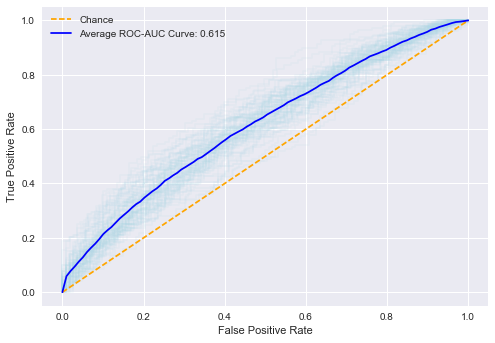

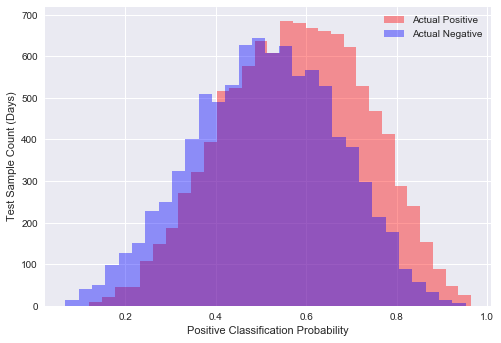

In [248]:
#Create visualizations for model performance

for i in range(len(roc_ix)):
    plt.plot(roc_ix[i], roc_val[i], alpha = 0.1, color = 'lightblue')
   
plt.plot(roc_ix[0], roc_ix[0], linestyle = '--', color = 'orange', label = 'Chance')
plt.plot(mean_fpr, mean_tpr, color = 'blue', label = 'Average ROC-AUC Curve: {}'.format(round(np.mean(group_auc_overall), 3)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
 

plt.hist(pos_pred, alpha = 0.4, bins = 30, color = 'red', label = 'Actual Positive')
plt.hist(neg_pred, alpha = 0.4, bins = 30, color = 'blue', label = 'Actual Negative')
plt.xlabel('Positive Classification Probability')
plt.ylabel('Test Sample Count (Days)')
plt.legend()
plt.show()

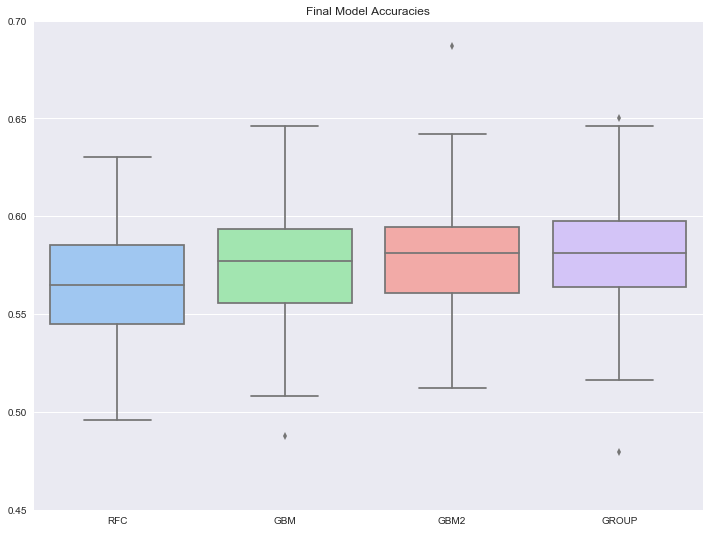

In [249]:
import seaborn as sns

plt.figure(figsize=(12,9))

df_outcomes = pd.DataFrame()
df_outcomes['RFC'] = full_rfc
df_outcomes['GBM'] = full_gbm
df_outcomes['GBM2'] = full_gbm2
df_outcomes['GROUP'] = full_group

sns.boxplot(data=df_outcomes, palette = 'pastel').set_title('Final Model Accuracies')
plt.ylim(0.45, 0.70)
plt.show()

In [250]:
mod_gain = []
null_gain = []
for i in range(len(my_avg_gain_loss_overall)):
    mod_gain.append(my_avg_gain_loss_overall[i] / avg_cost_basis_overall[i])
    null_gain.append(null_avg_gain_loss_overall[i] / avg_cost_basis_overall[i])
    
mod_gain.sort()
null_gain.sort()

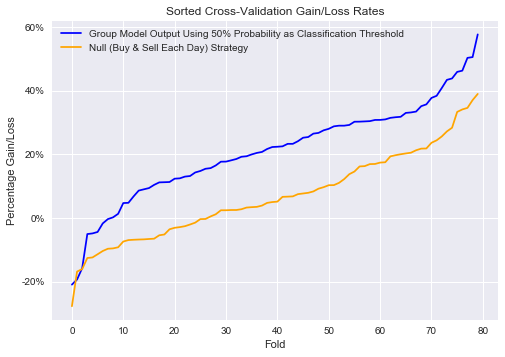

In [263]:
from matplotlib.pyplot import gca
plt.plot(mod_gain, label = 'Group Model Output Using 50% Probability as Classification Threshold', color = 'blue')
plt.plot(null_gain, label = 'Null (Buy & Sell Each Day) Strategy', color = 'orange')
plt.title('Sorted Cross-Validation Gain/Loss Rates')
plt.xlabel('Fold')
plt.ylabel('Percentage Gain/Loss')
plt.legend()
gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in gca().get_yticks()]) 
plt.show()